In [1]:
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import glob
#import splat
from popsims.relations import polynomial_relation
from popsims.filtermags import filterMag
#import splat.empirical as spe
from tqdm import tqdm
import popsims
%matplotlib inline

In [2]:
#plot overlap of filters



In [3]:
#add WISE 
WISE_MAGS={'i': (23.8, 0.1),
          'z': (20.147, 0.08),
          'y': (18.942, 0.13),
          'J': (17.291, 0.044)}

wise_df=pd.Series()
wise_df['spt']=38
wise_df['teff']=800
wise_df['names']='WISE1810−1010.'
for p in ['LSST', 'SDSS', 'PANSTARRS']:
    wise_df[p+'_G']=np.nan
    wise_df[p+'_G_er']=np.nan
    wise_df[p+'_R']=np.nan
    wise_df[p+'_R_er']=np.nan
    wise_df[p+'_I']=WISE_MAGS['i'][0]-5*np.log10(8.9/10)
    wise_df[p+'_I_er']=0.1
    wise_df[p+'_Z']=WISE_MAGS['z'][0]-5*np.log10(8.9/10)
    wise_df[p+'_Z_er']=0.1
    wise_df[p+'_Y']=WISE_MAGS['y'][0]-5*np.log10(8.9/10)
    wise_df[p+'_Y_er']=0.15

/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_19699/3849704147.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wise_df=pd.Series()


In [4]:
#compute conversions from Gaia to LSST
def compute_lsst_mags(gaia_id, gmag):
    #read spectrum
    vals={'source_id':gaia_id}
    try:
        sp=read_gaia_spec(gaia_id)
        for m in ['LSST_G', 'LSST_R', 'LSST_I', 'LSST_Y', 'LSST_Z']:
            color= get_colors(s, 'GAIA_G', m)
            vals.update({m:(color[0]+gmag, color[1])})
    except:
        pass
        
    return vals


def get_correct_filter_name(flt):
    #reformat from by 
    f= flt.split('_')
    if f[-1]=='ps1':
        return 'PANSTARRS_'+(f[0]).upper()
    else:
        return  flt
    

def spt_to_teff(spt, sd=True):
    if sd:
        if spt >25:  
            return  spe.typeToTeff(spt,  reverse=False, ref='pecaut')[0].value
        else:
            return spe.typeToTeff(spt, reverse=False, ref='gonzales18')[0].value
    if not sd:
        return spe.typeToTeff(teff,  reverse=False, ref='pecaut')[0].value
    
def teff_to_spt(teff, sd=True):
    if sd:
        if teff <1600: #use dwarfs for higher teff 
            return  spe.typeToTeff(teff,  reverse=True, ref='pecaut')[0]
        else:
            return spe.typeToTeff(teff, reverse=True, ref='gonzales18')[0]
    if not sd:
        return  spe.typeToTeff(teff,  reverse=True, ref='pecaut')[0]
    
def compute_mags_from_reference(spt, mag_key, ref):
    vals, unc= polynomial_relation(spt, 'spt', mag_key, ref, nsample=1000, xerr=0.0)
    return vals, unc

#functions
def k_clip_fit(x, y, sigma_y, sigma = 5, n=6):
    
    '''Fit a polynomial to y vs. x, and k-sigma clip until convergence
    hard-coded, returns mask array
    '''
    
    not_clipped = np.ones_like(y).astype(bool)
    n_remove = 1
    
    while n_remove > 0:

        best_fit = np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))
        
        norm_res = (np.abs(y - best_fit(x)))/(sigma_y)
        remove = np.logical_and(norm_res >= sigma, not_clipped == 1)
        n_remove = sum(remove)
        not_clipped[remove] = 0   
        
    return  not_clipped

def fit_with_nsigma_clipping(x, y, y_unc, n, sigma=4.):
    not_clipped = k_clip_fit(x, y, y_unc, sigma = sigma)
    return not_clipped, np.poly1d(np.polyfit(x[not_clipped], y[not_clipped], n))

#label sd, usd and esd
def get_sd_type(spt):
    for c in ['sd', 'esd', 'usd']:
        if spt.startswith(c):
            return c
        
def compute_colors(s, xkey, ykey):
    xmag= filterMag(s.wave, s.flux, s.noise, s.flux_unit, xkey)
    ymag= filterMag(s.wave, s.flux, s.noise, s.flux_unit, ykey)
    return xmag[0]-ymag[0], (xmag[1]**2+ymag[1]**2)**0.5

/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: R

/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: R

/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: R

/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: R

/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: R

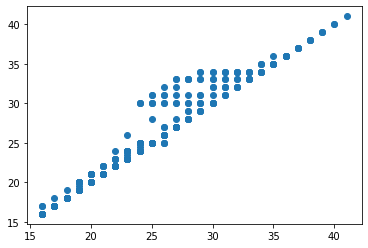

In [5]:
#spectroscopic data for color information

In [6]:
zhang_tpls= np.load('/Volumes/LaCie/popsimsdata/zhang_subdwarfs_templates.npy',  allow_pickle=True)[0]

lodieu_tpls= np.load('/Volumes/LaCie/popsimsdata/lodieu_templates.npy',  allow_pickle=True)[0]

lepine_tpls= np.load('/Volumes/LaCie/popsimsdata/lepinelpsm_subdwarfs_templates.npy',  allow_pickle=True)[0]

kesseli_tpls= np.load('/Volumes/LaCie/popsimsdata/kesseli_subdwarfs_templates.npy',  allow_pickle=True)[0]

ModuleNotFoundError: No module named 'splat'

In [ ]:
#define all color terms to compute
COLOR_TERMS=['Gaia_GandLSST_G',
             'Gaia_RandLSST_R',
             
            'SDSS_GandLSST_G',
            'SDSS_RandLSST_G',
            'SDSS_RandLSST_R',
            'SDSS_IandLSST_I',
            'SDSS_ZandLSST_Z',
             
            'PANSTARRS_RandLSST_R',
            'PANSTARRS_IandLSST_I',
            'PANSTARRS_ZandLSST_Z',
            'PANSTARRS_YandLSST_Y',
             
            'LSST_GandLSST_R',
            'LSST_RandLSST_Z',
            'LSST_IandLSST_Z']

zhang_sd_corrections={}
for c in COLOR_TERMS:
    zhang_sd_corrections.update({c: [compute_colors(sp, c.split('and')[0], c.split('and')[-1]) for \
                                     sp in tqdm(zhang_tpls['spectra'])]})
    
lodieu_sd_corrections={}
for c in COLOR_TERMS:
    lodieu_sd_corrections.update({c: [compute_colors(sp, c.split('and')[0], c.split('and')[-1]) for \
                                     sp in tqdm(lodieu_tpls['spectra'])]})
    
lepine_sd_corrections={}
for c in COLOR_TERMS:
    lepine_sd_corrections.update({c: [compute_colors(sp, c.split('and')[0], c.split('and')[-1]) for \
                                     sp in tqdm(lepine_tpls['spectra'])]})

In [ ]:
kesseli_sd_corrections={}
for c in COLOR_TERMS:
    kesseli_sd_corrections.update({c: [compute_colors(sp, c.split('and')[0], c.split('and')[-1]) for \
                                     sp in tqdm(kesseli_tpls['spectra'])]})

In [ ]:
#add spectral type information 
zhang_color_df=pd.DataFrame(zhang_sd_corrections)
zhang_color_df['spt']=zhang_tpls['spt']
zhang_color_df['numspt']=[splat.typeToNum(x) for x in zhang_tpls['spt']]
zhang_color_df['teff']=[ spt_to_teff(x, sd=True) for x in zhang_color_df['numspt']]
zhang_color_df['subdwarf_type']=[get_sd_type(x) for x in zhang_tpls['spt']]
#only select M and L dwarfs
zhang_color_df=zhang_color_df[zhang_color_df.numspt>=15]

#add spectral type information 
lodieu_color_df=pd.DataFrame(lodieu_sd_corrections)
lodieu_color_df['spt']=[x.name.split('_')[0] for x in lodieu_tpls['spectra'] ]
lodieu_color_df['numspt']=[splat.typeToNum(x) for x in lodieu_color_df['spt'].values]
lodieu_color_df['teff']=[spt_to_teff(x, sd=True) for x in lodieu_color_df['numspt'].values]
lodieu_color_df['subdwarf_type']=[get_sd_type(x) for x in lodieu_color_df['spt'].values]
#this should only have r and i (no z, y or g for 0.6-0.8 micron specrtra)
lodieu_color_df=lodieu_color_df[lodieu_color_df.numspt>=15]

#add spectral type information 
lepine_color_df=pd.DataFrame(lepine_sd_corrections)
lepine_color_df['spt']=lepine_tpls['sptype']
lepine_color_df['numspt']=[splat.typeToNum(x) for x in lepine_color_df['spt'].values]
lepine_color_df['teff']=[spt_to_teff(x, sd=True) for x in lepine_color_df['numspt'].values]
lepine_color_df['subdwarf_type']=[get_sd_type(x) for x in lepine_color_df['spt'].values]
lepine_color_df=lepine_color_df[lepine_color_df.numspt>=15]



#add spectral type information 
kesseli_color_df=pd.DataFrame(kesseli_sd_corrections)
kesseli_color_df['spt']=kesseli_tpls['sptype']
kesseli_color_df['numspt']=[splat.typeToNum(x) for x in kesseli_color_df['spt'].values]
kesseli_color_df['teff']=[spt_to_teff(x, sd=True) for x in kesseli_color_df['numspt'].values]
kesseli_color_df['subdwarf_type']=[get_sd_type(x) for x in kesseli_color_df['spt'].values]
kesseli_color_df=kesseli_color_df[kesseli_color_df.numspt>=15]


In [ ]:
for k in ['Gaia_GandLSST_G',  'SDSS_GandLSST_G', 'SDSS_ZandLSST_Z',
          'PANSTARRS_ZandLSST_Z', 'PANSTARRS_YandLSST_Y', 'LSST_GandLSST_R', 'LSST_RandLSST_Z',
       'LSST_IandLSST_Z']:
    lepine_color_df[k]=[(np.nan, np.nan) for x in range(len(lepine_color_df))]

In [ ]:
#lodieu_color_df['SDSS_ZandLSST_Z']

In [ ]:
combined_colors_df=pd.concat([zhang_color_df, lodieu_color_df, lepine_color_df])

In [ ]:
combined_colors_df=(combined_colors_df[combined_colors_df.numspt>12]).reset_index(drop=True)

In [ ]:
fig, ax=plt.subplots(figsize=(12, 4))

im=ax.scatter(np.vstack(combined_colors_df['LSST_RandLSST_Z'].values)[:,0], 
          (np.vstack(combined_colors_df['LSST_GandLSST_R'].values)[:,0]),
          c=combined_colors_df['numspt'].values)
plt.colorbar(im)

In [ ]:
#lepine_color_df['LSST_GandSDSS_R']
data=[ zhang_color_df, kesseli_color_df]

labels=[ 'Zhang', 'Kesseli']

colors=[ '#FF4136', '#111111']

In [ ]:
FITS= np.load('/Volumes/LaCie/popsimsdata/abs_mag_relations.npy', allow_pickle=True)[0]


In [ ]:
def get_sd_models(model='line2021'):
    #ADD models
    sdmodels=np.load('/Volumes/LaCie/popsimsdata/subdwarfs_models_{}.npy'.format(model), allow_pickle=True)[0]
    additional_keys=['SDSS_G', 'SDSS_R', 'SDSS_I', 'SDSS_Z', '2MASS J', '2MASS H', '2MASS K']
    all_keys= np.concatenate([additional_keys, np.unique(np.concatenate([x.split('and') for x in COLOR_TERMS]))])
    model_vals=dict(zip(all_keys, []))


    #compute values from filtermags
    #ADD ADDITIONAL FITS FOR SLOAN AND 2 MASS TO TAKE ADAVTANGE OF METAL-POOR MODELS
    
    for k in all_keys:
        mags= np.vstack([filterMag(x.wave, x.flux, x.noise, x.flux_unit, k) for x in sdmodels['spectra']])
        model_vals[k]=mags[:,0] 
        model_vals[k+'_er']= 0.#(mags[:,1]**2+ np.nanmedian(df_sd_dwarfs[k+'_er'])**2)**0.5#add a fudicial 0.1 scatter

    sdmodel_df=pd.DataFrame(model_vals)
    sdmodel_df['spt']=[ teff_to_spt(x, sd=True) for x in sdmodels['teff']]
    sdmodel_df['spt']= np.array(sdmodel_df['spt'])
    sdmodel_df['teff']= sdmodels['teff']
    sdmodel_df['z']= sdmodels['z']
    return sdmodel_df

In [ ]:
#sdmodel_df_drift0= get_sd_models(model='drift')
sdmodel_df_line= get_sd_models(model='line2021')
sdmodel_df_cond= get_sd_models(model='cond')

In [ ]:
sdmodel_df_cond

In [ ]:
k

In [ ]:
#(sdmodel_df_line[k.split('and')[1]])[mask_model]-(sdmodel_df_line[k.split('and')[0]])[mask_model],

In [ ]:
#

In [ ]:
from scipy.interpolate import UnivariateSpline

In [ ]:
#for lepine spectra, we can only use r and i bands 

In [ ]:
def bin_by_spt_bin(grid, xvals, yvals, yvalserr):
    #bin on a uniformly-spaced grid
    res=[]
    dx= grid[1]-grid[0]
    for x in grid:
        mask= np.logical_and(xvals>=x, xvals<x+dx)
        yx=np.nanmedian(yvals[mask])
        yxerr=(np.nanstd(yvals[mask])**2+np.nanmedian(yvalserr[mask])**2)**0.5
        
        res.append([yx, yxerr])
        
    return res
    

In [ ]:
grid=np.arange(10, 40)
                    

In [ ]:
for k in  COLOR_TERMS:
    fig, (ax, ax1)=plt.subplots(figsize=(12, 6), ncols=2)
    try:
        for idx  in range(len(data)):
            #plot dwarfs

            mask= np.logical_and(np.vstack(data[idx][k])[:,0]>0, data[idx].subdwarf_type=='sd')
            
            grid=np.arange(10, 40)
            xvyv=bin_by_spt_bin(grid, data[idx].numspt.values[mask], \
                    np.vstack(data[idx][k])[:,0][mask],
                    np.vstack(data[idx][k])[:,1][mask])
            ax.errorbar(grid, np.array(  xvyv)[:,0], fmt='s',\
                        alpha=0.5, label=labels[idx]+' sd', c=colors[idx])
            
            grid=np.arange(500, 3000, 150)
            xvyv=bin_by_spt_bin(grid, data[idx].teff.values[mask], \
                    np.vstack(data[idx][k])[:,0][mask],
                    np.vstack(data[idx][k])[:,1][mask])
            ax1.errorbar(grid, np.array(  xvyv)[:,0], fmt='s',\
                         alpha=0.5, label=labels[idx]+' sd', c=colors[idx])

            #plot usd and esd
            mask= np.logical_and(np.vstack(data[idx][k])[:,0]>0, data[idx].subdwarf_type !='sd')
            ax.errorbar(data[idx].numspt[mask], np.vstack(data[idx][k])[:,0][mask], \
                        yerr=np.vstack(data[idx][k])[:,1][mask], fmt='+',\
                        alpha=0.5, label=labels[idx]+' esd & usd', c=colors[idx])
            ax1.errorbar(data[idx].teff[mask],  np.vstack(data[idx][k])[:,0][mask], \
                        yerr=np.vstack(data[idx][k])[:,1][mask], fmt='+',\
                         alpha=0.5, label=labels[idx]+' esd & usd', c=colors[idx])



        ax1.set(title=k.replace('and', '-'), xlabel='Teff', ylabel=k.replace('and', '-'))
        ax.set(title=k.replace('and', '-'), xlabel='Spectral Type', ylabel=k.replace('and', '-'))



        mask_model=sdmodel_df_line.z==-1.5

        ax.errorbar(sdmodel_df_line.spt[mask_model], \
                    (sdmodel_df_line[k.split('and')[0]])[mask_model]-(sdmodel_df_line[k.split('and')[1]])[mask_model], \
                    fmt='s', alpha=0.5, label='LowZ=-1.5', c='#2ECC40')
        ax1.errorbar(sdmodel_df_line.teff[mask_model], 
                     (sdmodel_df_line[k.split('and')[0]])[mask_model]-(sdmodel_df_line[k.split('and')[1]])[mask_model], \
                     fmt='s', alpha=0.5, label='LowZ=-1.5', c='#2ECC40')

        mask_model=sdmodel_df_line.z==-2.0
        ax.errorbar(sdmodel_df_line.spt[mask_model],
                    (sdmodel_df_line[k.split('and')[0]])[mask_model]-(sdmodel_df_line[k.split('and')[1]])[mask_model], \
                    fmt='+', alpha=0.5, label='LowZ=-2.0', c='#2ECC40')
        ax1.errorbar(sdmodel_df_line.teff[mask_model], 
                     (sdmodel_df_line[k.split('and')[0]])[mask_model]-(sdmodel_df_line[k.split('and')[1]])[mask_model],
                     fmt='+', alpha=0.5, label='LowZ=-2.0', c='#2ECC40')
        
        #mask for sds 
        zhangmask= np.logical_and(np.vstack(zhang_color_df[k])[:,0]>0, zhang_color_df.subdwarf_type=='sd')
        kesselimask= np.logical_and(np.vstack(kesseli_color_df[k])[:,0]>0, kesseli_color_df.subdwarf_type=='sd')
        mask_model=sdmodel_df_line.z==-1.5


        tall= np.concatenate([zhang_color_df.teff[zhangmask],\
                          kesseli_color_df.teff[kesselimask],\
                           sdmodel_df_line.teff[mask_model]])
    
        xall=np.concatenate([zhang_color_df.numspt[zhangmask],\
                          kesseli_color_df.numspt[kesselimask],\
                           sdmodel_df_line.spt[mask_model]])

        yall= np.concatenate([ np.vstack(zhang_color_df[k])[:,0][zhangmask],\
                             np.vstack(kesseli_color_df[k])[:,0][kesselimask],\
        (sdmodel_df_line[k.split('and')[0]])[mask_model]-(sdmodel_df_line[k.split('and')[1]])[mask_model]])

        
        yerrall= 0.1*np.ones_like(yall)

        
        t= np.arange(500, 3000, 150)
        
        x=np.arange(14, 40)
        
        y=np.array(bin_by_spt_bin(x,xall, yall, yerrall))[:,0]
        yerr=np.array(bin_by_spt_bin(x,xall, yall, yerrall))[:,1]
        

        mask= np.logical_or.reduce([np.isnan(x), np.isnan(y), np.isnan(yerr)])

        #_, fit= fit_with_nsigma_clipping(x[~mask], y[~mask], yerr[~mask], 5, sigma=5)
        fit=UnivariateSpline(x[~mask][np.argsort(x[~mask])], y[~mask][np.argsort(x[~mask])])
        m=np.nanmedian(yerr)

       
        
         
        t= np.arange(500, 3000, 150)

        y=np.array(bin_by_spt_bin(t,tall, yall, yerrall))[:,0]
        
        yerr=np.array(bin_by_spt_bin(t,tall, yall, yerrall))[:,1]
        
        mask2= np.logical_or.reduce([np.isnan(t), np.isnan(y), np.isnan(yerr)])
        
        #m2, fit2= fit_with_nsigma_clipping(t[~mask2], y[~mask2], yerr[~mask2], 5, sigma=5)
        fit2=UnivariateSpline(t[~mask2][np.argsort(t[~mask2])], y[~mask2][np.argsort(t[~mask2])])
        m2= np.nanmedian(yerr)

        xgrid=np.linspace(np.nanmin(x[~mask]),np.nanmax(x[~mask]), 20) 
        tgrid=np.linspace(np.nanmin(t[~mask2]),np.nanmax(t[~mask2]), 20) 


        ax.plot(x, fit(x), c='k')
        
        ax1.plot(t, fit2(t), c='k')
        
        #save fits
        scatter= np.nanmedian(yerr)
        scatter2= np.nanmedian(yerr)
        


        FITS['colors_spt']['subdwarfs'].update({k: {'x': 'spt',
                                              'y': k,
                                              'fit':fit,\
                                              'scatter': scatter, \
                                              'method': 'spline',\
                                              'range':  (np.nanmin(x[~mask]),\
                                                         np.nanmax(x[~mask])), \
                                             'x0':0}})

        FITS['colors_teff']['subdwarfs'].update({k: {'x': 'teff',
                                              'y': k,
                                              'fit':fit2,\
                                              'scatter': scatter, \
                                              'method': 'spline',\
                                              'range':  (np.nanmin(t[~mask2]),\
                                                         np.nanmax(t[~mask2])), \
                                             'x0':0}})

        plt.tight_layout()
        ax.minorticks_on()
        ax1.minorticks_on()
        ax.legend(fontsize=12)
        
        
    except:
        pass

    
        
    

    plt.savefig('/users/caganze/research/figures/color_relations_sd{}.jpeg'.format(k), bbox_inches='tight')

      

In [ ]:
#load in cross-matched tables
zhang_abs_mags_tables=ascii.read('/volumes/LaCie/zhang_subdwarfs_gaia_ps1_sdss.csv').to_pandas()
zhang_abs_mags_tables['numspt']=zhang_abs_mags_tables.sptype.apply(splat.typeToNum).values
zhang_abs_mags_tables['subdwarf_type']=[get_sd_type(x) for x in zhang_abs_mags_tables.sptype]

simbad_abs_mags_tables=ascii.read('/volumes/LaCie/simbad_subdwarfs_gaia_ps1_sdss.csv').to_pandas()
simbad_abs_mags_tables['numspt']=simbad_abs_mags_tables.simbad_type.apply(splat.typeToNum).values
simbad_abs_mags_tables['subdwarf_type']=[get_sd_type(x) for x in simbad_abs_mags_tables.simbad_type]


abs_mags_tables=pd.concat([zhang_abs_mags_tables, simbad_abs_mags_tables] )
abs_mags_tables['teff']=[ spt_to_teff(x, sd=True) for x in abs_mags_tables['numspt']]

In [ ]:
#zhang_abs_mags_tables.columns

In [ ]:
def get_abs_mags(m, merr, p, perr):
    ds= 1000/np.random.normal(p, perr, 1000)
    ms= np.random.normal(m, merr, 1000)
    res= ms-5*np.log10(ds/10.0)
    return np.nanmedian(res), np.nanstd(res)

In [ ]:
#first compute SDSS_ABS_MAGS
for k in 'ugrizy':
    for sur in ['SDSS', 'PS1_PSF']:
        m=abs_mags_tables['{}_{}'.format(sur, k)].values.astype(float)
        merr=abs_mags_tables['{}_{}_er'.format(sur, k)].values.astype(float)
        p=abs_mags_tables['parallax (mas)'].values.astype(float)
        perr=abs_mags_tables[ 'parallax_er (mas)'].values.astype(float)
        vs=[get_abs_mags(mx, merrx, px, perrx) for mx, merrx, px, perrx in zip(m, merr, p, perr)]
        absm=np.vstack(vs)[:,0]
        absmerr=np.vstack(vs)[:,1]

        abs_mags_tables['abs_{}_{}'.format(sur, k)]= absm
        abs_mags_tables['abs_{}_{}_er'.format(sur, k)]= absmerr

In [ ]:
#let's just focus on r i z
fig, ax=plt.subplots()
#ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_i)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_r)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_SDSS_r)
#ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_z)

In [ ]:
fig, ax=plt.subplots()
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_i)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_SDSS_i)

In [ ]:
fig, ax=plt.subplots()
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_PS1_PSF_z)
ax.scatter(abs_mags_tables.numspt, abs_mags_tables.abs_SDSS_z)

In [ ]:
#compute r z and i
corr_r=FITS['colors_spt']['subdwarfs']['SDSS_RandLSST_R']['fit'](abs_mags_tables.numspt)
corr_i=FITS['colors_spt']['subdwarfs']['SDSS_IandLSST_I']['fit'](abs_mags_tables.numspt)
corr_z=FITS['colors_spt']['subdwarfs']['SDSS_ZandLSST_Z']['fit'](abs_mags_tables.numspt)

In [ ]:
abs_mags_tables['abs_LSST_R']=abs_mags_tables.abs_SDSS_r.values-corr_r
abs_mags_tables['abs_LSST_I']=abs_mags_tables.abs_SDSS_i.values-corr_i
abs_mags_tables['abs_LSST_Z']=abs_mags_tables.abs_SDSS_z.values-corr_z

abs_mags_tables['abs_LSST_R_er']=abs_mags_tables.abs_SDSS_r_er
abs_mags_tables['abs_LSST_I_er']=abs_mags_tables.abs_SDSS_i_er
abs_mags_tables['abs_LSST_Z_er']=abs_mags_tables.abs_SDSS_z_er

In [ ]:
#SCALE THE MODELS
mask_data= np.logical_and.reduce([abs_mags_tables.subdwarf_type.values=='sd',
                                   abs_mags_tables.abs_LSST_I.values > 0.,
                                  abs_mags_tables.numspt >=24.])
                                  
                                 
sdmodel_df_line_mask= np.logical_and.reduce([ sdmodel_df_line.spt.between(24, 26), 
                       sdmodel_df_line.z==-1.5])

model_scale= np.nanmedian(abs_mags_tables.abs_LSST_I.values[mask_data])\
- np.nanmedian(sdmodel_df_line.LSST_I[sdmodel_df_line_mask])


In [ ]:
model_scale

In [ ]:
#scale models
fig, ax=plt.subplots(figsize=(12,8))
mask= np.logical_and(abs_mags_tables.subdwarf_type.values=='sd', abs_mags_tables.abs_LSST_I>2.5 )

ax.scatter(abs_mags_tables.numspt[mask], abs_mags_tables.abs_LSST_I[mask],  s=10)
ax.scatter(abs_mags_tables.numspt[mask_data], abs_mags_tables.abs_LSST_I[mask_data],  s=50)
ax.scatter(sdmodel_df_line.spt, sdmodel_df_line.LSST_I+model_scale, marker='^')

In [ ]:
ABS_MAG_USED={}

In [ ]:
for k in 'riz':
    print (k.upper())

    fig, ax=plt.subplots(figsize=(10, 6))
    
    mask_data=np.logical_and(abs_mags_tables.subdwarf_type.values=='sd',
                             abs_mags_tables['abs_LSST_{}'.format(k.upper())] >2.5)
    
    mask_model= np.logical_and.reduce([sdmodel_df_line.z==-1.5])
    
    xall= np.concatenate([abs_mags_tables.numspt[mask_data],
                         sdmodel_df_line.spt[mask_model]])
    
    yall= np.concatenate([abs_mags_tables['abs_LSST_{}'.format(k.upper())][mask_data],
                          sdmodel_df_line['LSST_{}'.format(k.upper())][mask_model]+model_scale])
    
    median_error=np.nanmedian(abs_mags_tables['abs_LSST_{}_er'.format(k.upper())][mask_data])
    
    yerrall= np.concatenate([abs_mags_tables['abs_LSST_{}_er'.format(k.upper())][mask_data],
                             median_error*np.ones_like( sdmodel_df_line.spt[mask_model])])
                             
                             

    mask= np.logical_or.reduce([np.isnan(xall),np.isnan(yall),np.isnan(yerrall)])
    #print (mask)
    m, fit= fit_with_nsigma_clipping(xall[~mask], yall[~mask], yerrall[~mask], 4, sigma=2)
    #fit=UnivariateSpline(xall[~mask][np.argsort(xall[~mask])], yall[~mask][np.argsort(xall[~mask])])

    xgrid=np.arange(10, 40)
    ax.plot(xgrid, fit(xgrid), c='k')

    ax.errorbar(abs_mags_tables.numspt[mask_data], abs_mags_tables['abs_LSST_{}'.format(k.upper())][mask_data],  
                fmt='s', alpha=0.5, label='Sd Data', c='#0074D9')
    ax.errorbar(sdmodel_df_line.spt[mask_model], sdmodel_df_line['LSST_{}'.format(k.upper())][mask_model]+model_scale, \
                fmt='s', alpha=0.5, label='LowZ=-1.5', c='#2ECC40')
    #print (fit(25))
    #l;''
    ax.set(xlabel='Spectral Type', ylabel=r'M$_{}$'.format(k))
    ax.legend()
    
    
        #save fits
    scatter= (np.nanmedian(yerrall[~mask])**2+ np.nanmedian((yall[~mask]-fit(xall[~mask]))**2))**0.5

    FITS['absmags_spt']['subdwarfs'].update({'LSST_{}'.format(k.upper()): {'x': 'spt',
                                          'y': k,
                                          'fit':fit,\
                                          'scatter': scatter, \
                                          'method': 'polynomial',\
                                          'range':  (np.nanmin(xall[~mask]),\
                                                     np.nanmax(xall[~mask])), \
                                         'x0':0}})
    
    ABS_MAG_USED.update({'LSST_{}'.format(k.upper()): {'x': xall[~mask], 
                                                      'y':yall[~mask], 
                                                      'yerr':yerrall[~mask],
                                                     }})
    
    
    plt.savefig('/users/caganze/research/figures/absmag_relations_sd_LSST{}.jpeg'.format(k.upper()), bbox_inches='tight')
    


In [ ]:
bins=np.arange(10, 40)
df=pd.DataFrame()
df['spt']=['sd'+splat.typeToNum(x) for x in bins]
for k in ABS_MAG_USED.keys():
    x=ABS_MAG_USED[k]['x']
    y=ABS_MAG_USED[k]['y']
    yerr=ABS_MAG_USED[k]['yerr']
    vls= np.vstack(bin_by_spt_bin(bins, x, y, yerr))
    
    df[k]=['{:.1f}+/-{:.1f}'.format(x[0], x[1]) for x in vls]
    
df.replace('nan+/-nan', '').to_latex('/users/caganze/research/popsimsdata/lsst_subdwarfs.tex', index=False)
df.replace('nan+/-nan', '')

In [ ]:
np.save('/Volumes/LaCie/popsimsdata/abs_mag_relations.npy', [FITS], allow_pickle=True) 
np.save('/users/caganze/research/popsimsdata/abs_mag_relations.npy', [FITS], allow_pickle=True) 

In [ ]:
FITS

In [ ]:
bj

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)

x = df_sd_dwarfs.spt
y =  df_sd_dwarfs[k]
names =df_sd_dwarfs.names.apply( clean_names).values

fig,ax = plt.subplots()
sc = plt.scatter(x,y, s=100)

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format( " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)
    
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

ax.set(xlabel='Spectral Type', ylabel='LSST r')

plt.show()


In [ ]:
[x.name for x in sub_dwarf_tpls['spectra']]

In [ ]:
ss=[x for x in sub_dwarf_tpls['spectra'] if x.name in ['ULAS_J130710.22+151103.4_sdL8_OSIRIS_GTC46-14A_Primeval-IV.fits',
                                                      'LSPM J1218+1325']]

In [ ]:
%matplotlib inline
ss[0].plot()

In [ ]:
fig, ax=plt.subplots()
ax.plot(ss[1].wave, ss[1].flux, label='LSPM J1218+1325')
ax.legend()

In [ ]:
#splat.classifyByStandard(ss[1], all=True, plot=True)

In [ ]:
#gaiia --> parallaxes (trent and will parallax spreadsheet )

In [ ]:
s=splat.getSpectrum(lucky=True)

In [ ]:
s[0].plot()

In [ ]:
len(simbad_merged)

In [ ]:
simbad_merged.columns

In [ ]:
pd.read_csv('/binary_look')